## **Import Libraries** ##

In [1]:
import os
import numpy as np
from tqdm import tqdm  # for the progress bar

## **Loading Feature Vectors and Their Labels** ##

In [2]:
# Function to Load Feature Vectors and Labels
def loadFeaturesAndLabels(features_path):

    features = [] # list to store the feature vectors
    labels = [] # list to store the labels
    
    # checking if the path exists
    if not os.path.exists(features_path):
        raise ValueError(f"Path {features_path} does not exist.")
    # checking if the path is a directory
    if not os.path.isdir(features_path):
        raise ValueError(f"Path {features_path} is not a directory.")
    
    # going through through the folders and load the features
    for fruit_folder in tqdm(os.listdir(features_path), unit="folder", desc=f"Loading Features from {features_path}"):

        fruit_folder_path = os.path.join(features_path, fruit_folder) # creating complete path of the fruit folder
        
        if os.path.isdir(fruit_folder_path):  # checking if it's an valid path to a folder
            for featureVectorFile in os.listdir(fruit_folder_path):

                feature_file_path = os.path.join(fruit_folder_path, featureVectorFile) # creating complete path of the feature file
                
                if featureVectorFile.endswith('.npy'):  # checking if its a valid feature file
                    labels.append(fruit_folder[:-2].strip())  # the folder name is the label (not taking the numbers at the end)

                    featureVector = np.load(feature_file_path)
                    features.append(featureVector)
                    
                    
    return np.array(features), np.array(labels)

## **Using Colour Histogram Features** ##

### **Loading Feature and Label Data** ##

In [3]:
# loading the train and test feature data and labels
trainFeatures, trainLabels = loadFeaturesAndLabels('../features/img_ColourHist_Features/Training')
testFeatures, testLabels = loadFeaturesAndLabels('../features/img_ColourHist_Features/Testing')

Loading Features from ../features/img_ColourHist_Features/Training: 100%|██████████| 160/160 [00:09<00:00, 16.34folder/s]
Loading Features from ../features/img_ColourHist_Features/Testing: 100%|██████████| 159/159 [00:02<00:00, 54.66folder/s]


### **Linear Discriminant Analysis (LDA)** ###

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# training LDA
LDA_Model = LinearDiscriminantAnalysis()
LDA_Model.fit(trainFeatures, trainLabels)

# number of features in LDA
print(f"Number of Features in LDA: {LDA_Model.scalings_.shape[1]}")

# predicitng using only LDA
testPredictions_LDA = LDA_Model.predict(testFeatures)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA)
print(f"LDA Classifier Accuracy on Colour Histogram Features: {accuracy*100:.2f}%")

# saving the LDA model
lda_model_filename = '../saved_models/LDA_Model_1.pkl'
joblib.dump(LDA_Model, lda_model_filename)
print(f"LDA classifier model saved to {lda_model_filename}")


Training Features Shape: (79921, 60)
Testing Features Shape: (26668, 60)
Number of Labels: 132
Number of Features in LDA: 52
LDA Classifier Accuracy on Colour Histogram Features: 85.11%
LDA classifier model saved to ../saved_models/LDA_Model_1.pkl


### **LDA + Linear SVM** ###

Training Features Shape: (79921, 60)
Testing Features Shape: (26668, 60)
Number of Labels: 132

Shape of Features after LDA:
Training Features Shape after LDA: (79921, 52)
Testing Features Shape after LDA: (26668, 52)


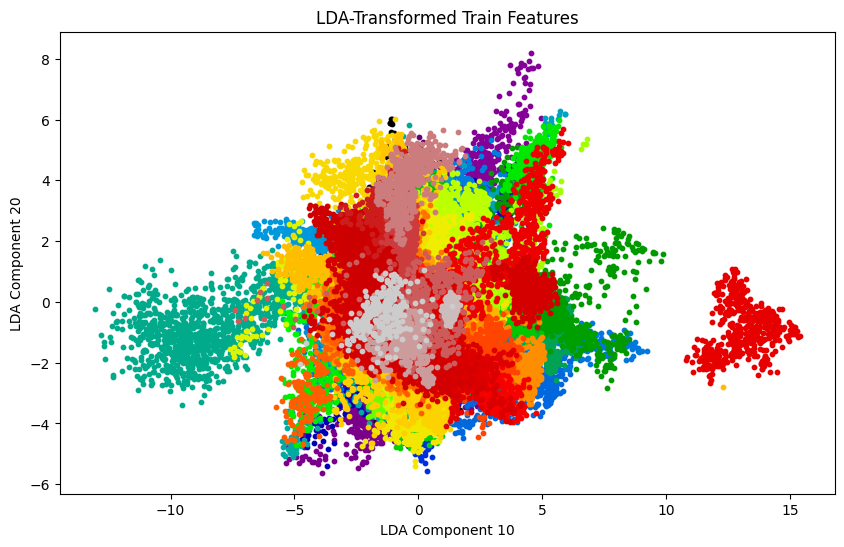

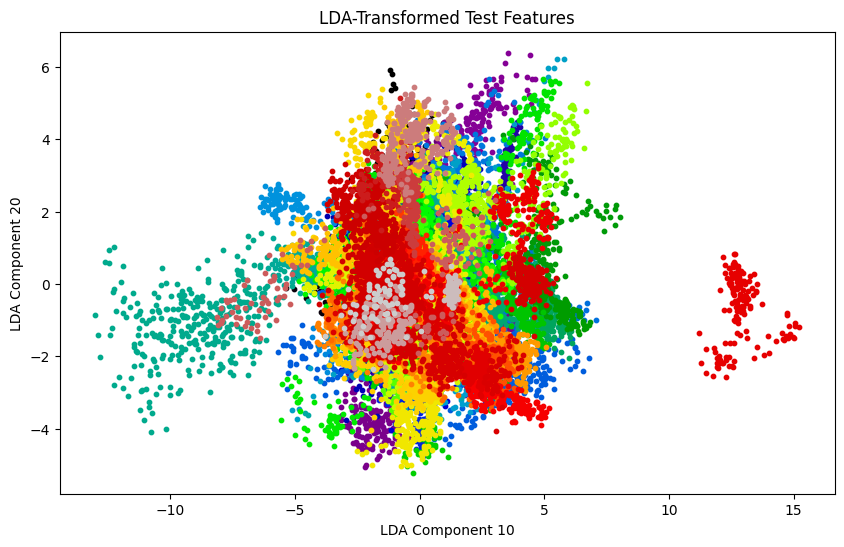

LDA + Linear SVM on Colour Histogram Accuracy: 98.54%
SVM (LDA) model saved to ../saved_models/LDA_SVM_Model_1.pkl sucessfully


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# loading LDA
lda_model_filename = '../saved_models/LDA_Model_1.pkl'
LDA_Model = joblib.load(lda_model_filename)

# transforming training and testing features for SVM
trainFeaturesLDA = LDA_Model.transform(trainFeatures)
testFeaturesLDA = LDA_Model.transform(testFeatures)

# checking the shape of the features and labels after LDA
print("\nShape of Features after LDA:")
print(f"Training Features Shape after LDA: {trainFeaturesLDA.shape}")
print(f"Testing Features Shape after LDA: {testFeaturesLDA.shape}")

# # visualizing 2 LDA-transformed features 
# plt.figure(figsize=(10, 6))
# plt.scatter(trainFeaturesLDA[:, 9], trainFeaturesLDA[:, 19], label='Train', marker = 'o', cmap='viridis')
# plt.scatter(testFeaturesLDA[:, 9], testFeaturesLDA[:, 19], label='Test', marker='x', cmap='virdis')
# plt.title('LDA-Transformed Features')
# plt.xlabel('LDA Component 10')
# plt.ylabel('LDA Component 20')
# plt.legend()
# plt.show()

# visualizing 2 LDA-transformed train features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(trainLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (trainLabels == label)
    plt.scatter(trainFeaturesLDA[l, 9], trainFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size
plt.title('LDA-Transformed Train Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# visualizing 2 LDA-transformed test features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(testLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (testLabels == label)
    plt.scatter(testFeaturesLDA[l, 9], testFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size

plt.title('LDA-Transformed Test Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# training linear SVM model on the LDA-transformed features
LDA_SVM_Model = SVC(kernel='linear')
LDA_SVM_Model.fit(trainFeaturesLDA, trainLabels)

# making predictions on the test set
testPredictions_LDA_SVM = LDA_SVM_Model.predict(testFeaturesLDA)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA_SVM)
print(f"LDA + Linear SVM on Colour Histogram Accuracy: {accuracy*100:.2f}%")

# # display 5 incorrectly classified images (also displaying the image index in testFeatures)
# print("\nFinding some Incorrectly Classified Images:")
# incorrectIndices = np.where(testPredictions_LDA_SVM != testLabels)[0][:5]
# for i in incorrectIndices:
#     print(f"Image Index: {i} - Predicted: {testPredictions_LDA_SVM[i]} - Actual: {testLabels[i]}")

# saving the model 
lda_svm_model_filename = '../saved_models/LDA_SVM_Model_1.pkl'
joblib.dump(LDA_SVM_Model, lda_svm_model_filename)
print(f"SVM (LDA) model saved to {lda_svm_model_filename} sucessfully")

## **Using HOG + Colour Histogram Features** ##

### **Loading Feature and Label Data** ##

In [6]:
# loading the train and test feature data and labels
trainFeatures, trainLabels = loadFeaturesAndLabels('../features/img_HOG_ColourHist_Features/Training')
testFeatures, testLabels = loadFeaturesAndLabels('../features/img_HOG_ColourHist_Features/Testing')

Loading Features from ../features/img_HOG_ColourHist_Features/Training: 100%|██████████| 161/161 [00:08<00:00, 19.27folder/s]
Loading Features from ../features/img_HOG_ColourHist_Features/Testing: 100%|██████████| 160/160 [00:02<00:00, 56.40folder/s]


### **Linear Discriminant Analysis (LDA)** ###

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# using StandardScaler to standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trainFeatures = scaler.fit_transform(trainFeatures)
testFeatures = scaler.transform(testFeatures)

# training LDA
LDA_Model = LinearDiscriminantAnalysis()
LDA_Model.fit(trainFeatures, trainLabels)

# number of features in LDA
print(f"Number of Features in LDA: {LDA_Model.scalings_.shape[1]}")

# predicitng using only LDA
testPredictions_LDA = LDA_Model.predict(testFeatures)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA)
print(f"LDA Classifier Accuracy on HOG + Colour Histogram Features: {accuracy*100:.2f}%")

# saving the LDA model
lda_model_filename = '../saved_models/LDA_Model_2.pkl'
joblib.dump(LDA_Model, lda_model_filename)
print(f"LDA Classifier Model saved to {lda_model_filename}")


Training Features Shape: (79921, 960)
Testing Features Shape: (26668, 960)
Number of Labels: 132
Number of Features in LDA: 131
LDA Classifier Accuracy on HOG + Colour Histogram Features: 94.64%
LDA Classifier Model saved to ../saved_models/LDA_Model_2.pkl


### **LDA + Linear SVM** ###

Training Features Shape: (79921, 960)
Testing Features Shape: (26668, 960)
Number of Labels: 132

Shape of Features after LDA:
Training Features Shape after LDA: (79921, 131)
Testing Features Shape after LDA: (26668, 131)


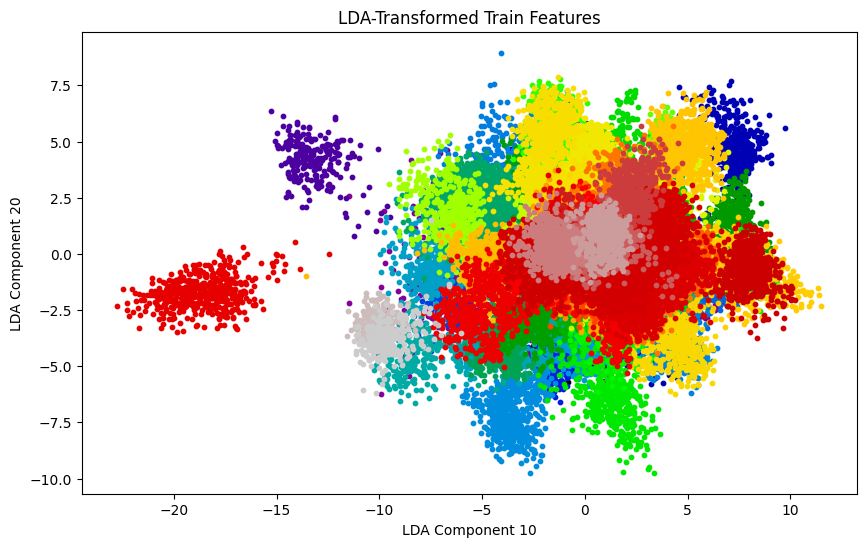

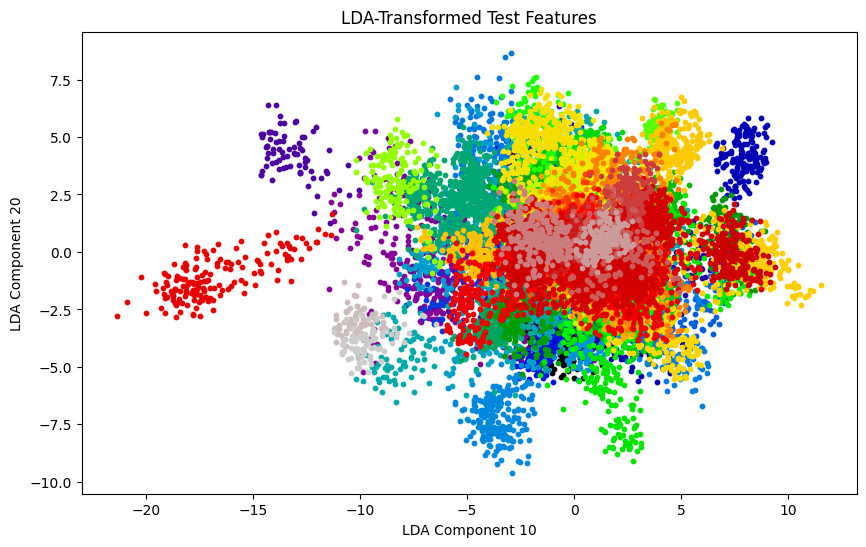

LDA + Linear SVM on HOG + Colour Histogram Accuracy: 98.90%
SVM (LDA) Model saved to ../saved_models/LDA_SVM_Model_2.pkl sucessfully


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# loading LDA
lda_model_filename = '../saved_models/LDA_Model_2.pkl'
LDA_Model = joblib.load(lda_model_filename)

# transforming training and testing features for SVM
trainFeaturesLDA = LDA_Model.transform(trainFeatures)
testFeaturesLDA = LDA_Model.transform(testFeatures)

# checking the shape of the features and labels after LDA
print("\nShape of Features after LDA:")
print(f"Training Features Shape after LDA: {trainFeaturesLDA.shape}")
print(f"Testing Features Shape after LDA: {testFeaturesLDA.shape}")

# # visualizing 2 LDA-transformed features 
# plt.figure(figsize=(10, 6))
# plt.scatter(trainFeaturesLDA[:, 9], trainFeaturesLDA[:, 19], label='Train', marker = 'o', cmap='viridis')
# plt.scatter(testFeaturesLDA[:, 9], testFeaturesLDA[:, 19], label='Test', marker='x', cmap='virdis')
# plt.title('LDA-Transformed Features')
# plt.xlabel('LDA Component 10')
# plt.ylabel('LDA Component 20')
# plt.legend()
# plt.show()

# visualizing 2 LDA-transformed train features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(trainLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (trainLabels == label)
    plt.scatter(trainFeaturesLDA[l, 9], trainFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size
plt.title('LDA-Transformed Train Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# visualizing 2 LDA-transformed test features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(testLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (testLabels == label)
    plt.scatter(testFeaturesLDA[l, 9], testFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size

plt.title('LDA-Transformed Test Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# training linear SVM model on the LDA-transformed features
LDA_SVM_Model = SVC(kernel='linear')
LDA_SVM_Model.fit(trainFeaturesLDA, trainLabels)

# making predictions on the test set
testPredictions_LDA_SVM = LDA_SVM_Model.predict(testFeaturesLDA)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA_SVM)
print(f"LDA + Linear SVM on HOG + Colour Histogram Accuracy: {accuracy*100:.2f}%")

# # display 5 incorrectly classified images (also displaying the image index in testFeatures)
# print("\nFinding some Incorrectly Classified Images:")
# incorrectIndices = np.where(testPredictions_LDA_SVM != testLabels)[0][:5]
# for i in incorrectIndices:
#     print(f"Image Index: {i} - Predicted: {testPredictions_LDA_SVM[i]} - Actual: {testLabels[i]}")

# saving the model 
lda_svm_model_filename = '../saved_models/LDA_SVM_Model_2.pkl'
joblib.dump(LDA_SVM_Model, lda_svm_model_filename)
print(f"SVM (LDA) Model saved to {lda_svm_model_filename} sucessfully")

## **Using LBP Histogram + Colour Histogram Features** ##

### **Loading Test and Feature Data** ###

In [9]:
# loading the train and test feature data and labels
trainFeatures, trainLabels = loadFeaturesAndLabels('../features/img_ColourHist_LBP_Hist_Features/Training')
testFeatures, testLabels = loadFeaturesAndLabels('../features/img_ColourHist_LBP_Hist_Features/Testing')

Loading Features from ../features/img_ColourHist_LBP_Hist_Features/Training: 100%|██████████| 160/160 [00:09<00:00, 17.46folder/s]
Loading Features from ../features/img_ColourHist_LBP_Hist_Features/Testing: 100%|██████████| 159/159 [00:03<00:00, 51.18folder/s]


### **Linear Discriminant Analysis (LDA)** ###

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# using StandardScaler to standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trainFeatures = scaler.fit_transform(trainFeatures)
testFeatures = scaler.transform(testFeatures)

# training LDA
LDA_Model = LinearDiscriminantAnalysis()
LDA_Model.fit(trainFeatures, trainLabels)

# number of features in LDA
print(f"Number of Features in LDA: {LDA_Model.scalings_.shape[1]}")

# predicitng using only LDA
testPredictions_LDA = LDA_Model.predict(testFeatures)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA)
print(f"LDA Classifier Accuracy on LBP Histogram + Colour Histogram Features: {accuracy*100:.2f}%")

# saving the LDA model
lda_model_filename = '../saved_models/LDA_Model_3.pkl'
joblib.dump(LDA_Model, lda_model_filename)
print(f"LDA Classifier Model saved to {lda_model_filename}")


Training Features Shape: (79921, 70)
Testing Features Shape: (26668, 70)
Number of Labels: 132
Number of Features in LDA: 61
LDA Classifier Accuracy on LBP Histogram + Colour Histogram Features: 89.86%
LDA Classifier Model saved to ../saved_models/LDA_Model_3.pkl


### **LDA + Linear SVM** ###

Training Features Shape: (79921, 70)
Testing Features Shape: (26668, 70)
Number of Labels: 132

Shape of Features after LDA:
Training Features Shape after LDA: (79921, 61)
Testing Features Shape after LDA: (26668, 61)


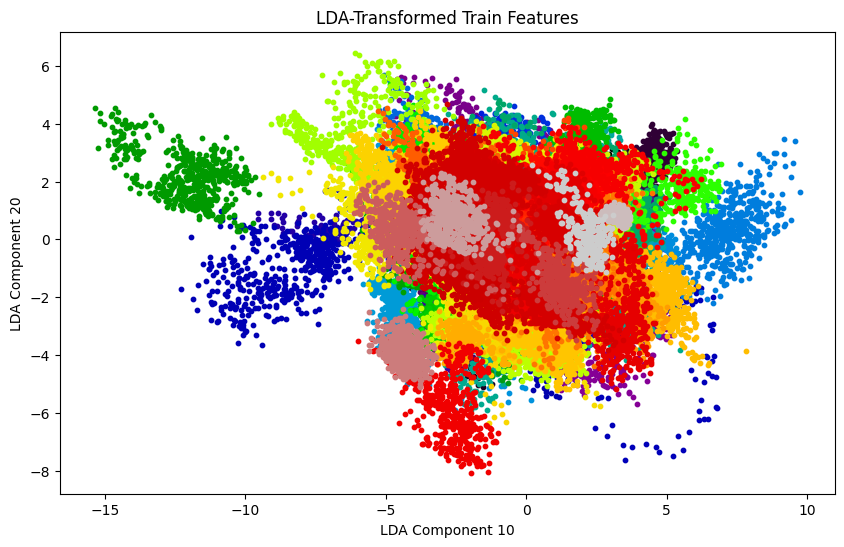

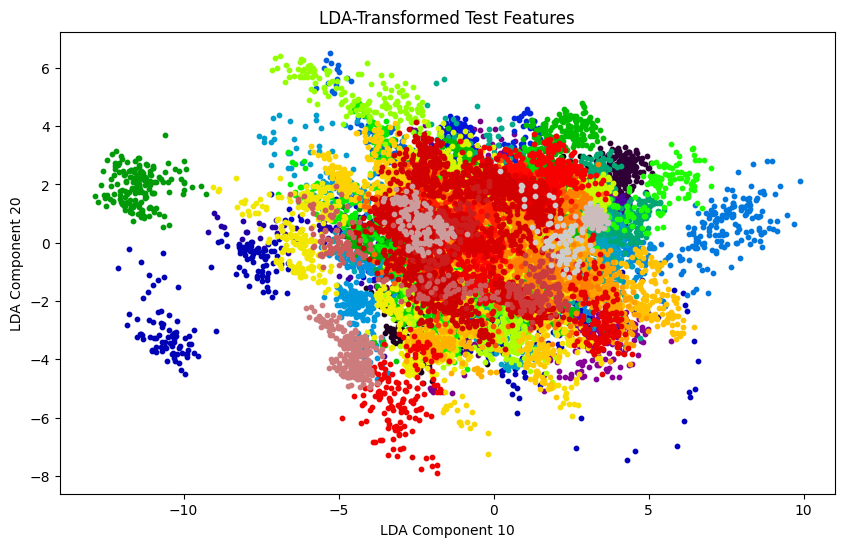

LDA + Linear SVM on LBP Histogram + Colour Histogram Accuracy: 99.22%
SVM (LDA) Model saved to ../saved_models/LDA_SVM_Model_3.pkl sucessfully


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# loading LDA
lda_model_filename = '../saved_models/LDA_Model_3.pkl'
LDA_Model = joblib.load(lda_model_filename)

# transforming training and testing features for SVM
trainFeaturesLDA = LDA_Model.transform(trainFeatures)
testFeaturesLDA = LDA_Model.transform(testFeatures)

# checking the shape of the features and labels after LDA
print("\nShape of Features after LDA:")
print(f"Training Features Shape after LDA: {trainFeaturesLDA.shape}")
print(f"Testing Features Shape after LDA: {testFeaturesLDA.shape}")

# # visualizing 2 LDA-transformed features 
# plt.figure(figsize=(10, 6))
# plt.scatter(trainFeaturesLDA[:, 9], trainFeaturesLDA[:, 19], label='Train', marker = 'o', cmap='viridis')
# plt.scatter(testFeaturesLDA[:, 9], testFeaturesLDA[:, 19], label='Test', marker='x', cmap='virdis')
# plt.title('LDA-Transformed Features')
# plt.xlabel('LDA Component 10')
# plt.ylabel('LDA Component 20')
# plt.legend()
# plt.show()

# visualizing 2 LDA-transformed train features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(trainLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (trainLabels == label)
    plt.scatter(trainFeaturesLDA[l, 9], trainFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size
plt.title('LDA-Transformed Train Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# visualizing 2 LDA-transformed test features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(testLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (testLabels == label)
    plt.scatter(testFeaturesLDA[l, 9], testFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size

plt.title('LDA-Transformed Test Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# training linear SVM model on the LDA-transformed features
LDA_SVM_Model = SVC(kernel='linear')
LDA_SVM_Model.fit(trainFeaturesLDA, trainLabels)

# making predictions on the test set
testPredictions_LDA_SVM = LDA_SVM_Model.predict(testFeaturesLDA)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA_SVM)
print(f"LDA + Linear SVM on LBP Histogram + Colour Histogram Accuracy: {accuracy*100:.2f}%")

# # display 5 incorrectly classified images (also displaying the image index in testFeatures)
# print("\nFinding some Incorrectly Classified Images:")
# incorrectIndices = np.where(testPredictions_LDA_SVM != testLabels)[0][:5]
# for i in incorrectIndices:
#     print(f"Image Index: {i} - Predicted: {testPredictions_LDA_SVM[i]} - Actual: {testLabels[i]}")

# saving the model 
lda_svm_model_filename = '../saved_models/LDA_SVM_Model_3.pkl'
joblib.dump(LDA_SVM_Model, lda_svm_model_filename)
print(f"SVM (LDA) Model saved to {lda_svm_model_filename} sucessfully")

## **Using HOG + LBP Histogram + Colour Histogram Features** ##

### **Loading Feature and Label Data** ##

In [12]:
# loading the train and test feature data and labels
trainFeatures, trainLabels = loadFeaturesAndLabels('../features/img_HOG_ColourHist_LBP_Hist_Features/Training')
testFeatures, testLabels = loadFeaturesAndLabels('../features/img_HOG_ColourHist_LBP_Hist_Features/Testing')

Loading Features from ../features/img_HOG_ColourHist_LBP_Hist_Features/Training: 100%|██████████| 160/160 [00:08<00:00, 18.20folder/s]
Loading Features from ../features/img_HOG_ColourHist_LBP_Hist_Features/Testing: 100%|██████████| 159/159 [00:02<00:00, 54.41folder/s]


### **Linear Discriminant Analysis (LDA)** ###

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# using StandardScaler to standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trainFeatures = scaler.fit_transform(trainFeatures)
testFeatures = scaler.transform(testFeatures)

# training LDA
LDA_Model = LinearDiscriminantAnalysis()
LDA_Model.fit(trainFeatures, trainLabels)

# number of features in LDA
print(f"Number of Features in LDA: {LDA_Model.scalings_.shape[1]}")

# predicitng using only LDA
testPredictions_LDA = LDA_Model.predict(testFeatures)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA)
print(f"LDA Classifier Accuracy on LBP Histogram + Colour Histogram + HOG Features: {accuracy*100:.2f}%")

# saving the LDA model
lda_model_filename = '../saved_models/LDA_Model_4.pkl'
joblib.dump(LDA_Model, lda_model_filename)
print(f"LDA Classifier Model saved to {lda_model_filename}")


Training Features Shape: (79921, 970)
Testing Features Shape: (26668, 970)
Number of Labels: 132
Number of Features in LDA: 131
LDA Classifier Accuracy on LBP Histogram + Colour Histogram + HOG Features: 95.31%
LDA Classifier Model saved to ../saved_models/LDA_Model_4.pkl


### **LDA + Linear SVM** ###

Training Features Shape: (79921, 970)
Testing Features Shape: (26668, 970)
Number of Labels: 132

Shape of Features after LDA:
Training Features Shape after LDA: (79921, 131)
Testing Features Shape after LDA: (26668, 131)


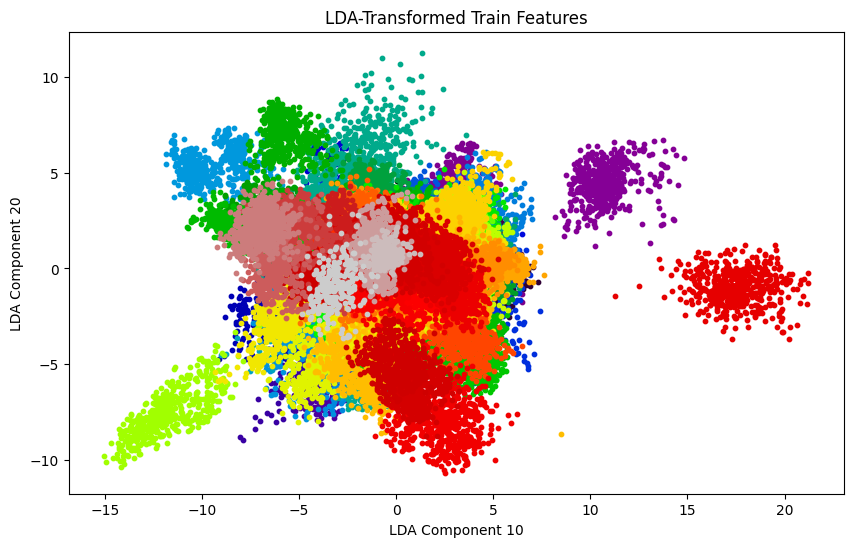

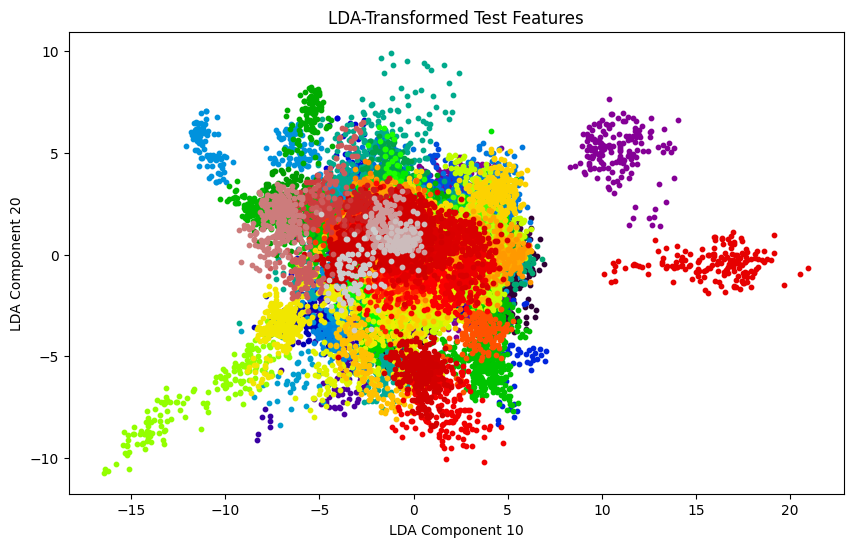

LDA + Linear SVM on LBP Histogram + Colour Histogram + HOG Accuracy: 99.12%
SVM (LDA) Model saved to ../saved_models/LDA_SVM_Model_4.pkl sucessfully


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

# checking the shape of the features and labels
print(f"Training Features Shape: {trainFeatures.shape}")
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(trainLabels))}")

# loading LDA
lda_model_filename = '../saved_models/LDA_Model_4.pkl'
LDA_Model = joblib.load(lda_model_filename)

# transforming training and testing features for SVM
trainFeaturesLDA = LDA_Model.transform(trainFeatures)
testFeaturesLDA = LDA_Model.transform(testFeatures)

# checking the shape of the features and labels after LDA
print("\nShape of Features after LDA:")
print(f"Training Features Shape after LDA: {trainFeaturesLDA.shape}")
print(f"Testing Features Shape after LDA: {testFeaturesLDA.shape}")

# # visualizing 2 LDA-transformed features 
# plt.figure(figsize=(10, 6))
# plt.scatter(trainFeaturesLDA[:, 9], trainFeaturesLDA[:, 19], label='Train', marker = 'o', cmap='viridis')
# plt.scatter(testFeaturesLDA[:, 9], testFeaturesLDA[:, 19], label='Test', marker='x', cmap='virdis')
# plt.title('LDA-Transformed Features')
# plt.xlabel('LDA Component 10')
# plt.ylabel('LDA Component 20')
# plt.legend()
# plt.show()

# visualizing 2 LDA-transformed train features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(trainLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (trainLabels == label)
    plt.scatter(trainFeaturesLDA[l, 9], trainFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size
plt.title('LDA-Transformed Train Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# visualizing 2 LDA-transformed test features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(testLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (testLabels == label)
    plt.scatter(testFeaturesLDA[l, 9], testFeaturesLDA[l, 19], 
                color=colour, s=10)  # s=10 for smaller marker size

plt.title('LDA-Transformed Test Features')
plt.xlabel('LDA Component 10')
plt.ylabel('LDA Component 20')
plt.show()

# training linear SVM model on the LDA-transformed features
LDA_SVM_Model = SVC(kernel='linear')
LDA_SVM_Model.fit(trainFeaturesLDA, trainLabels)

# making predictions on the test set
testPredictions_LDA_SVM = LDA_SVM_Model.predict(testFeaturesLDA)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA_SVM)
print(f"LDA + Linear SVM on LBP Histogram + Colour Histogram + HOG Accuracy: {accuracy*100:.2f}%")

# # display 5 incorrectly classified images (also displaying the image index in testFeatures)
# print("\nFinding some Incorrectly Classified Images:")
# incorrectIndices = np.where(testPredictions_LDA_SVM != testLabels)[0][:5]
# for i in incorrectIndices:
#     print(f"Image Index: {i} - Predicted: {testPredictions_LDA_SVM[i]} - Actual: {testLabels[i]}")

# saving the model 
lda_svm_model_filename = '../saved_models/LDA_SVM_Model_4.pkl'
joblib.dump(LDA_SVM_Model, lda_svm_model_filename)
print(f"SVM (LDA) Model saved to {lda_svm_model_filename} sucessfully")